In [370]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import random

mpld3.enable_notebook()


## Define a few building blocks for generating our input data

In [371]:
def constant(v, count = 100):
    return [v] * count

def jitter(v, amplitude):
    return [y + random.randint(0, amplitude) - amplitude * 0.5 for y in v]

def increasing(from_, to_, count = 100):
    return list(np.arange(from_, to_, (to_ - from_) / count))

def sin(base, amplitude, count = 100):
    return [base + amplitude * float(np.sin(2.0 * np.pi * t / count)) for t in range(count)]

### And a method for plotting and evaluating target algorithms

Note that it supports two algorithms. One `ref` (reference) and one that is the "algorithm-under-test" (`test`). This allows you to compare and benchmark one algorithm with another.

In [372]:
def evaluate(id, data, ref, test):
    fig, ax = plt.subplots()
    ax.plot(data, color="green", alpha=0.4)

    ts = []
    refs = []
    tests = []
    with open("test-%s.csv" % id, "w") as f:
        for i in range(len(data)):
            ts.append(data[i])

            res1 = ref(ts)
            refs.append(res1)

            res2 = test(ts)
            tests.append(res2)

            f.write("%d,%d\n" % (data[i], refs[i]))
        
    ax.plot(refs, color="red", ls='-.')
    ax.plot(tests, color="blue", ls=':')
    over = [i for i in range(len(data)) if data[i] > tests[i - 1]]
    print(over)

### This is our proposed algorithm

In [373]:
def unDef(a):
    if math.isnan(a):
        return True
    if math.isinf(a):
        return True
    return False


def ewma(series, com):
    """Exponentially weighted moving average, as found in pandas"""
    series = [1.0 * s for s in series]
    com = 1.0 * com
    N = len(series)
    ret = [0.0] * N
    if N == 0:
        return ret
    oldw = com / (1 + com)
    adj = oldw
    ret[0] = series[0] / (1 + com)
    for i in range(1, N):
        cur = series[i]
        prev = ret[i - 1]
        if unDef(cur):
            ret[i] = prev
        else:
            if unDef(prev):
                ret[i] = cur / (1 + com)
            else:
                ret[i] = (com * prev + cur) / (1 + com)

    for i in range(N):
        cur = ret[i]
        if not math.isnan(cur):
            ret[i] = ret[i] / (1.0 - adj)
            adj *= oldw
        else:
            if i > 0:
                ret[i] = ret[i - 1]
    return ret

def ewmstd_last(series, com):
    """Exponentially weighted moving standard deviation, last element"""
    m1st = ewma(series, com)
    m2nd = ewma([v*v for v in series], com)

    last = len(m1st) - 1
    t = m2nd[last] - m1st[last] * m1st[last]
    t *= (1.0 + 2.0 * com) / (2.0 * com)
    if t < 0:
        return 0
    return math.sqrt(t)

def ref(timeseries, factor=3):
    ts = timeseries[-20:]
    median = ewma(ts, 10)[-1]
    s = ewmstd_last(ts, 10)
    try:
        return (int)(factor * s + median + 1000)
    except ValueError:
        return 0
    
def test(timeseries, factor=3):
    ts = timeseries[-20:]
    median = ewma(ts, 10)[-1]
    s = ewmstd_last(ts, 10)
    try:
        return (int)(factor * s + median + 1000)
    except ValueError:
        return 0



### Test input 1

A heartbeat that comes every five to six minutes, throughout the day (changing because of load on the system). It varies a bit - up to 30 seconds between runs even if the load is static.

[1]


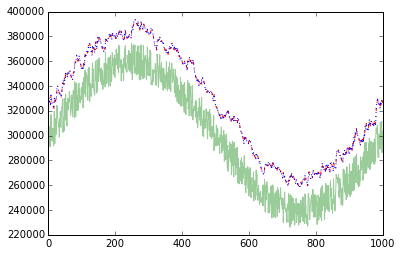

In [374]:
data = jitter(sin(5 * 60000, 60000, count=1000), 30000)

evaluate("sinejitter", data, ref, test)


### Test input 2

A constant heartbeat. Very predictive.

[]


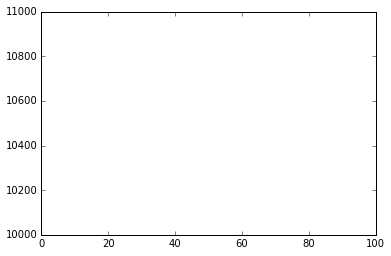

In [375]:
data = constant(10000)

evaluate("constant", data, ref, test)


### A more complex varying load

It also shows how the beat frequency was changed from once a minute to once every two minutes. This should of course be detected.

[300]


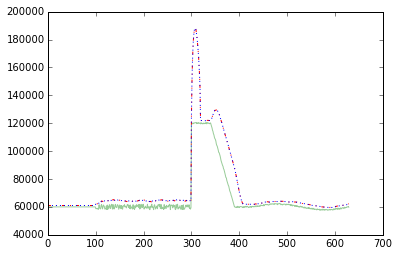

In [376]:
data = jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=200), 4000) \
        + jitter(constant(120000, count=40), 1000) \
        + jitter(increasing(120000, 60000, count=50), 1000) \
        + jitter(constant(60000, count=40), 1000) \
        + jitter(sin(60000, 2000, count=200), 1000)
        
evaluate("complex", data, ref, test)

### An increasingly jittery load

[969]


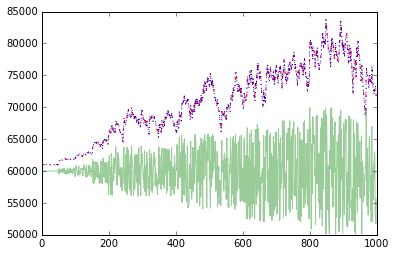

In [377]:
data = jitter(constant(60000, count=50), 0) \
        + jitter(constant(60000, count=50), 1000) \
        + jitter(constant(60000, count=50), 2000) \
        + jitter(constant(60000, count=50), 4000) \
        + jitter(constant(60000, count=200), 8000) \
        + jitter(constant(60000, count=200), 12000) \
        + jitter(constant(60000, count=200), 16000) \
        + jitter(constant(60000, count=200), 20000)
        
evaluate("incjitter", data, ref, test)

### Handling a large spike

If a service is down for a while, and goes up again, how well does our algorithm recover?

We can see that the effects from the spike lasts very long. Actually, up to 20 samples (which is the window we're using). This could be further improved.

[50]


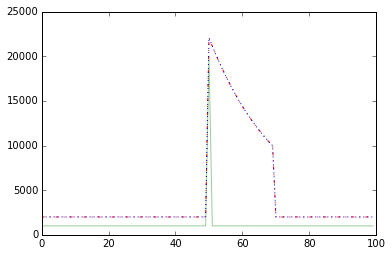

In [379]:
data = [1000] * 100
data[50] = 20000

evaluate("test2", data, ref, test)

### Handling double beats


[]


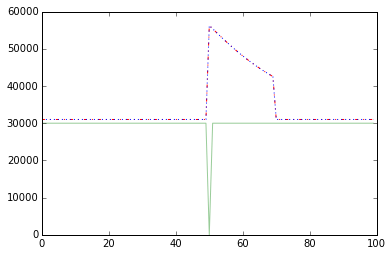

In [382]:
data = [30000] * 100
data[50] = 1

evaluate("test3", data, ref, test)